# Initial visualizations of your data

This notebook is meant to let you quickly look at your post-manually sorted data

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters
from neuraltda import topology
import glob
import string
%pylab inline
reload(topology)

Populating the interactive namespace from numpy and matplotlib


<module 'neuraltda.topology' from '/home/brad/code/NeuralTDA/neuraltda/topology.pyc'>

## Load the data

Set 'block_path' to the path of the folder containing your post-manually sorted data

In [2]:

block_path = '/mnt/cube/btheilma/experiments/B1087/phy040516/Pen03_Lft_AP0_ML500__Site01_Z2200__B1087_cat_P03_S01_1/'
spikes     = core.load_spikes(block_path)
clusters   = core.load_clusters(block_path)
trials     = events.load_trials(block_path)
fs         = core.load_fs(block_path)
rec        = 0 

In [99]:
topofolder = '/mnt/cube/btheilma/experiments/B1087/phy040516/Pen03_Lft_AP0_ML500__Site01_Z2200__B1087_cat_P03_S01_1/topology/bht060816/

In [100]:
persistence_files = sorted(glob.glob(os.path.join(topofolder, '*.pkl')))


None


## Plot rasters of each trial from each Good unit for all stims



/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060816-stim-A_scaled_burung-bettiPersistence.pkl
/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060816-stim-B_scaled_burung-bettiPersistence.pkl
/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060816-stim-C_scaled_burung-bettiPersistence.pkl
/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060816-stim-D_scaled_burung-bettiPersistence.pkl
/mnt/cube/btheilma/e

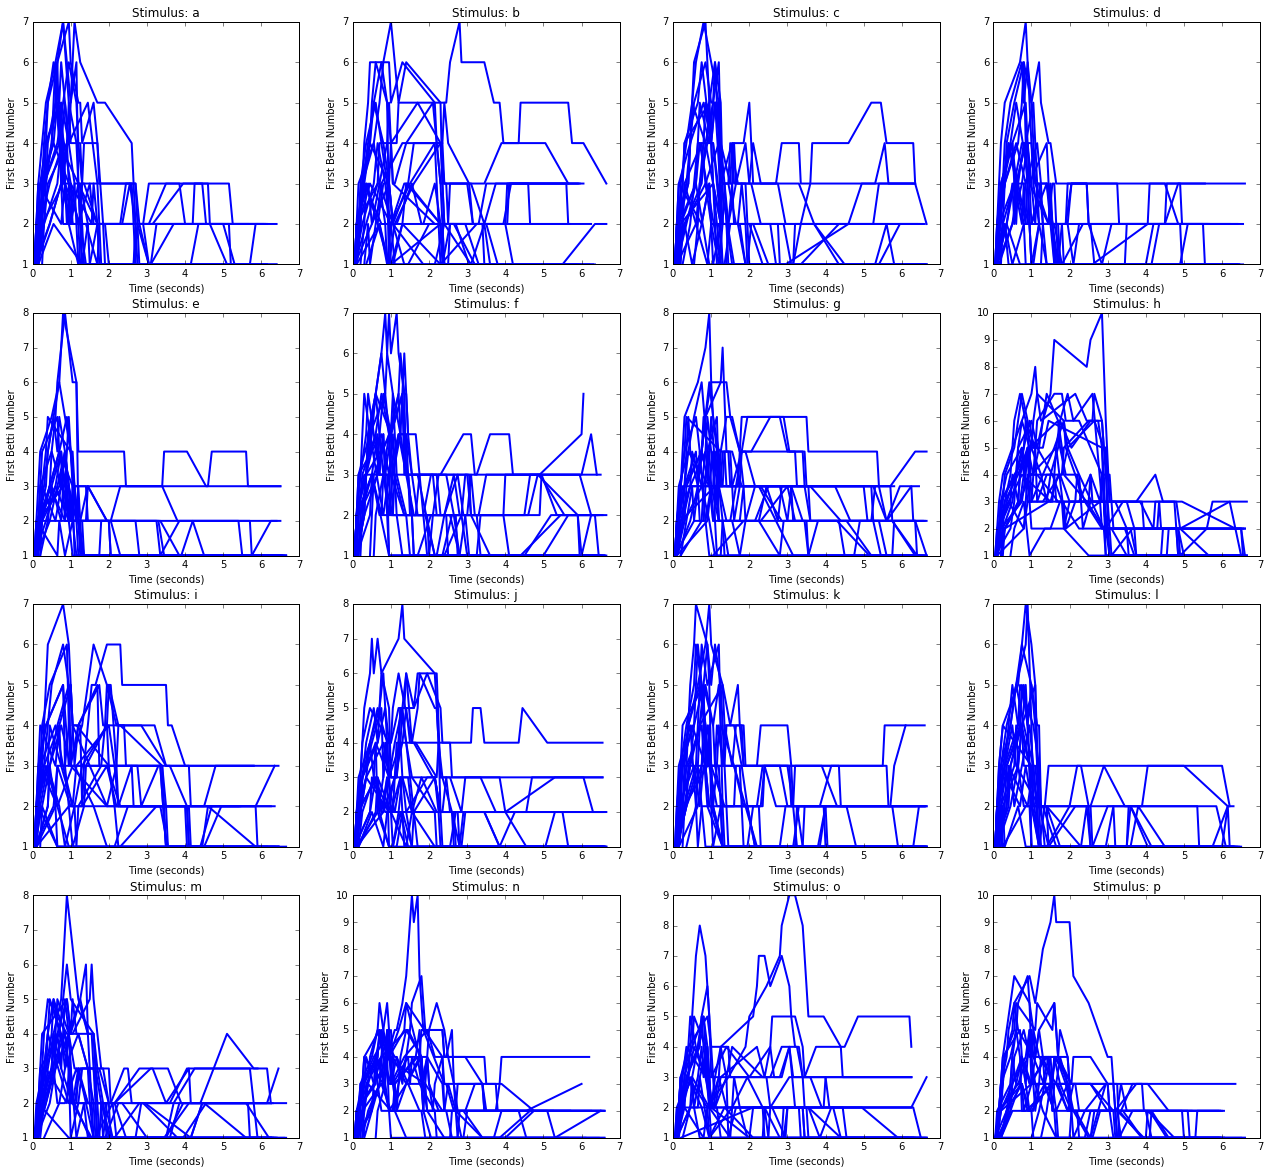

In [101]:
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)
for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    print(tf)

    betti=0
    ax = axs.flatten()[stimind]
    for trial in range(20):
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        
        
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*0.05
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
            

        #ax.set_xlim(0, 8)
        #ax.set_ylim(0, 10)
        pltcolor='b'
#        if stimname in ['stimA', 'stimB', 'stimC', 'stimD']:
#            pltcolor = 'r'
        ax.plot(betti1[:, 0], betti1[:,1], pltcolor, lw=2)
        ax.set_title('Stimulus: {}'.format(stimname))
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('First Betti Number')
plt.savefig('/home/brad/betti{}_timedep_50ms_stim2.png'.format(betti))

In [78]:
topofolder1 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/'
topofolder2 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/'
persistence_files1 = glob.glob(os.path.join(topofolder1, '*.pkl'))
persistence_files2 = glob.glob(os.path.join(topofolder2, '*.pkl'))
tfile1 = persistence_files1[0]
tfile2 = persistence_files2[0]
print(persistence_files1)
print(persistence_files2)

['/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060716-stim-A_scaled_burung-bettiPersistence.pkl', '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060716-stim-F_scaled_burung-bettiPersistence.pkl', '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060716-stim-O_scaled_burung-bettiPersistence.pkl', '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/B1235_cat_P01_S01_1-good_50ms_stim-bht060716-stim-P_scaled_burung-bettiPersistence.pkl', '/mnt/c

In [93]:
char(1)


TypeError: 'module' object is not callable

## See a cell / stim combo that looked interesting?  Plot it here!

In [ ]:
for stim in range(16):
    tf = persistence_files[stim]
    pdata = pickle.load(open(tf, 'r'))
    bettipts0 = []
    bettipts1 = []
    for trial in range(20):
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*0.05
            betti1[ind, 1] = filt[1][1]
        betti0 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti0[ind, 0] = filt[0]*0.05
            betti0[ind, 1] = filt[1][0]
        bettipt = [betti0[-1, 1], betti1[-1, 1]]
        bettipts0.append(betti0[-1, 1])
        bettipts1.append(betti1[-1, 1])
    plt.figure()
    plt.scatter(bettipts0, bettipts1)

## Plot Average, Gaussian Smoothed PSTHs for each Unit

In [ ]:
import test
import pandas as pd
reload(test)
times = np.array(range(0, 1000, 1))
testspikes = test.generate_ring_dataset(10, times, 0.02)
testtrials = pd.DataFrame({'time_samples': 0, 'stimulus_end': 1000, 'stimulus': 'test'}, index=[0])

## Plot rasters of each MUA unit

In [ ]:
reload(rasters)
good_cluster_ids = range(10)

# We have 16 stims, so let's go with a 4x4 subplot layout
subplot_xy = [1,2]
figsize = (22,20)
period = [0,0]
rec=0
fs = 1000.0

for clusterID in good_cluster_ids:
    fig = rasters.plot_unit_raster(testspikes, testtrials, clusterID, period, rec, fs, subplot_xy, figsize)
    #raster_fname = os.path.join(raster_dir, 'unit{}_raster.png'.format(str(clusterID)))
    fig.savefig('ring_test{}.png'.format(str(clusterID)))
    plt.close(fig)